In [104]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
import seaborn as sns
import matplotlib.pyplot as plt
import pmdarima as pm

In [105]:
api_string = 'https://api.flipsidecrypto.com/api/v2/queries/87905c1e-f4eb-4347-9b6a-8d16693d0614/data/latest'
eth = pd.read_json(api_string)
eth1 = eth

<AxesSubplot:xlabel='Date', ylabel='Cumulative Uniswap Users'>

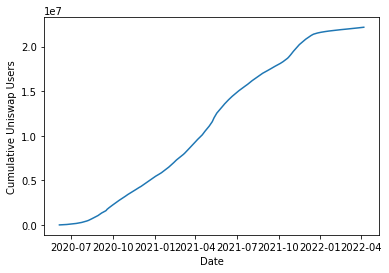

In [106]:
eth['Date'] = pd.to_datetime(eth['Date'])
df = eth[['Date','Cumulative Uniswap Users']]
df = df.iloc[::-1]
sns.lineplot(x="Date", y="Cumulative Uniswap Users",data = df)

In [107]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
eth = eth.reindex(index=eth.index[::-1]).reset_index(drop =True)
eth = eth['Cumulative Uniswap Users']
'''
result = adfuller(eth.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])'''
eth

0           140
1          2353
2          4831
3          7506
4         10223
         ...   
667    22149145
668    22155140
669    22160588
670    22165735
671    22170251
Name: Cumulative Uniswap Users, Length: 672, dtype: int64

Null Hypothesis can not be rejected, therefore data is non stationary

In [108]:
split = round(len(eth)*.7) - 1
train = eth[:split]
test = eth[split:]
len(test)

203

In [109]:
model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=9141.789, Time=0.43 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=9152.829, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=9151.484, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=9150.070, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=9150.937, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=9140.855, Time=0.20 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=9140.799, Time=0.07 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=9140.764, Time=0.13 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=9142.499, Time=0.55 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=9138.915, Time=0.09 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=9138.971, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=9140.649, Time=0.24 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=9139.004, Time=0.13 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 2.098 seconds
                      

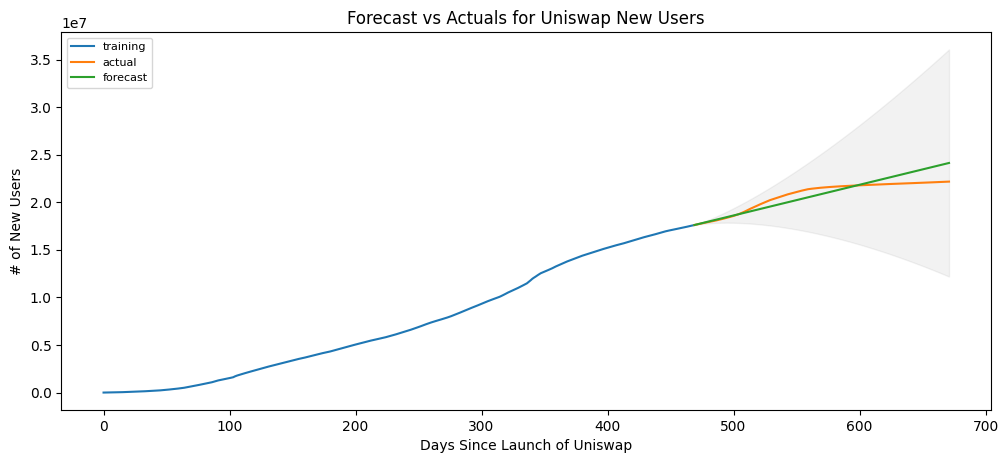

In [116]:
model = ARIMA(train, order=(3, 2, 0))  
model = model.fit()  

fc = model.forecast(len(test))  # 95% conf
result = model.get_forecast()
#fc, se, conf = model.forecast(15, alpha=0.05)  # 95% conf

forecast = model.get_forecast(len(test))
yhat = forecast.predicted_mean
conf = forecast.conf_int(alpha=0.05)


fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.05)
plt.title('Forecast vs Actuals for Uniswap New Users')
plt.ylabel('# of New Users')
plt.xlabel('Days Since Launch of Uniswap')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [111]:
import numpy as np

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

C:\Users\jackl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\jackl\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if sys.path[0] == '':


{'mape': 0.028773760584950785,
 'me': 114661.05871538444,
 'mae': 618415.3703325035,
 'mpe': 0.0046588068180731575,
 'rmse': 801615.5408153405,
 'acf1': 0.9862728544672261,
 'corr': 0.9189145877770435,
 'minmax': 0.027866097347447494}

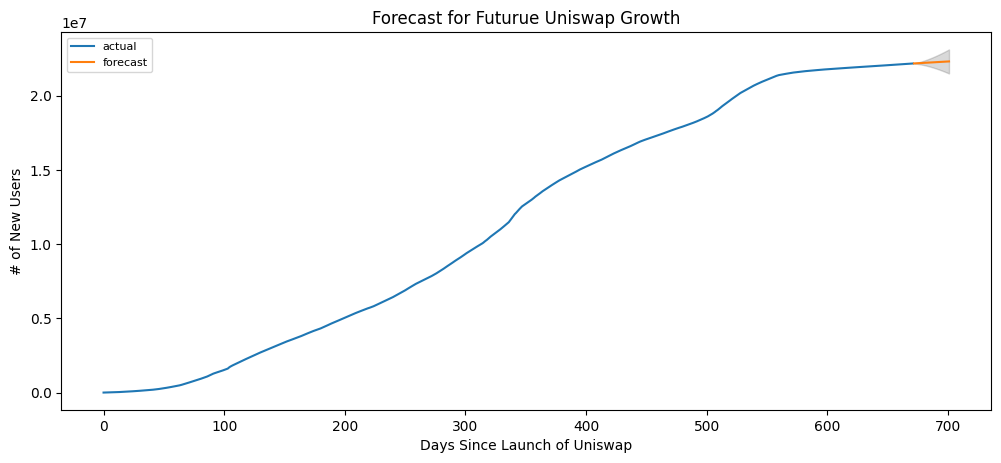

In [117]:
model = ARIMA(eth, order=(3, 2,0))  
model = model.fit()  

fc = model.forecast(30)  # 95% conf
result = model.get_forecast()

forecast = model.get_forecast(30)
yhat = forecast.predicted_mean
conf = forecast.conf_int(alpha=0.01)


fc_series = pd.Series(fc, index=fc.index)
lower_series = pd.Series(conf.iloc[:, 0], index=fc.index)
upper_series = pd.Series(conf.iloc[:, 1], index=fc.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(eth, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast for Futurue Uniswap Growth')
plt.ylabel('# of New Users')
plt.xlabel('Days Since Launch of Uniswap')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [113]:
print("New Users for 30 Days:" + str(fc_series.reset_index(drop = True).iloc[-1] - fc_series.reset_index(drop = True).iloc[0]))
print("Uppper 95% Confidence Interval: " + str((upper_series.reset_index(drop = True).iloc[0] - upper_series.reset_index(drop = True).iloc[-1]) * -1))

New Users for 30 Days:134348.97647657245
Uppper 95% Confidence Interval: 936315.5102538615
